In [1]:
import pandas as pd
import numpy as np
import cv2
import time
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#Define width and height of the desired image size
w, h = 256, 256

In [2]:
#Loading training and testing dataset that were previously imported in the Data Wrangling step
train = pd.read_csv('training_images_size.csv', sep='\t')
test = pd.read_csv('testing_images_size.csv', sep='\t')

## Explainatory Data Analaysis Based on Image Sizes:

In [3]:
#Summary statistics of the train set based on image sizes
train.describe()

,heights,widths,channels
count,1481.000000,1481.000000,1481.0
mean,3661.709656,2783.655638,3.0
std,501.958655,384.097922,0.0
min,640.000000,480.000000,3.0
25%,3264.000000,2448.000000,3.0
50%,3264.000000,3096.000000,3.0
75%,4128.000000,3096.000000,3.0
max,4160.000000,4128.000000,3.0


In [4]:
#Summary statistics of the test set based on image sizes
test.describe()

,heights,widths,channels
count,503.000000,503.000000,503.0
mean,3679.968191,2806.556660,3.0
std,536.263239,419.989063,0.0
min,640.000000,480.000000,3.0
25%,3264.000000,2448.000000,3.0
50%,4128.000000,3096.000000,3.0
75%,4128.000000,3096.000000,3.0
max,4160.000000,4128.000000,3.0


Based on the original image sizes, all testing and training images have really high resolution and need to be resized before any other analysis to reduce computational time. The average image size for a train image is (3662,2784,3) while the average for the test set is (3680, 2806, 3). 

In [5]:
#Define helper function for resizing images
def read_img(df):
    'reading images and convert all images to a size of (256, 256)'
    array = []
    for path in df.imagepath.values:
        img = cv2.imread(path, cv2.COLOR_RGB2GRAY)
        resize = cv2.resize(img, (h, w), cv2.INTER_LINEAR)
        array.append(resize)
    if 'type' in df.columns:
        img_df = {'type': df.type.values, 'img_array': array}
    else:
        img_df = np.array(array)
    return img_df

In [6]:
#Load train dataset as numpy array
start_time = time.time()
train_imgs = read_img(train)

print('Training data load time: {} seconds'.format(round(time.time() - start_time, 2)))

Training data load time: 311.67 seconds


In [7]:
#Convert train dictionary into a pandas dataframe
train_df = pd.DataFrame(train_imgs)

In [8]:
#Search for all test filenames
test_paths = glob('test/*')

#Embed all test filenames into a column of the test dataframe
test['imagepath'] = test_paths

#Load test set as numpy array instead of image sizes
start_time = time.time()
test_imgs = read_img(test)
print('Testing data load time: {} seconds'.format(round(time.time() - start_time, 2)))

Testing data load time: 120.56 seconds


In [9]:
#Save train dataframe to csv file for later use 
train_df.to_csv('training_df.csv')

## Investigating Image EXIF metadata

Let's take a look at the Exchangeable Image File format (EXIF metadata) to see how many different types of cameras were used to obtain the images. In addition, we are also interested in the datetime that the images were taken. 

In [10]:
from PIL.ExifTags import TAGS

def get_exif(path):
    img = Image.open(path)
    exif_data = img._getexif()
    if exif_data == None:
        exif_dict = 'NaN'
    else: 
        exif_dict = {TAGS.get(tag): value for tag, value in exif_data.items()}
    return exif_dict

### EXIF metadata for test set

In [11]:
test_make = []
test_datetime = []
for path in test_paths:
    exif_dict = get_exif(path)
    if exif_dict == 'NaN':
        test_make.append('NaN')
        test_datetime.append('NaN')
    else:
        test_make.append(exif_dict['Make'])
        test_datetime.append(exif_dict['DateTime'][:7])

In [12]:
test_make = [x.upper() for x in test_make]
date, count = np.unique(test_datetime, return_counts = True)

Text(0.5,1,'Images Taken by Month and Year')

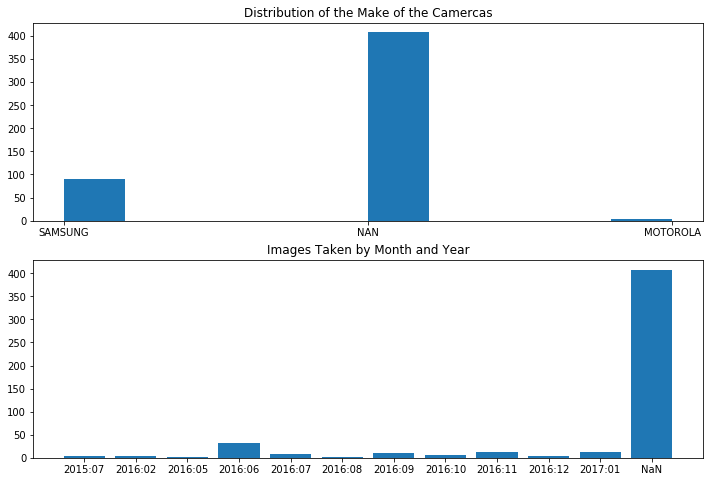

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
ax1.hist(test_make)
ax1.set_title('Distribution of the Make of the Camercas')
ax2 = fig.add_subplot(2,1,2)
ax2.bar(sorted(date), count)
ax2.set_title('Images Taken by Month and Year')

### EXIF metadata for the train set

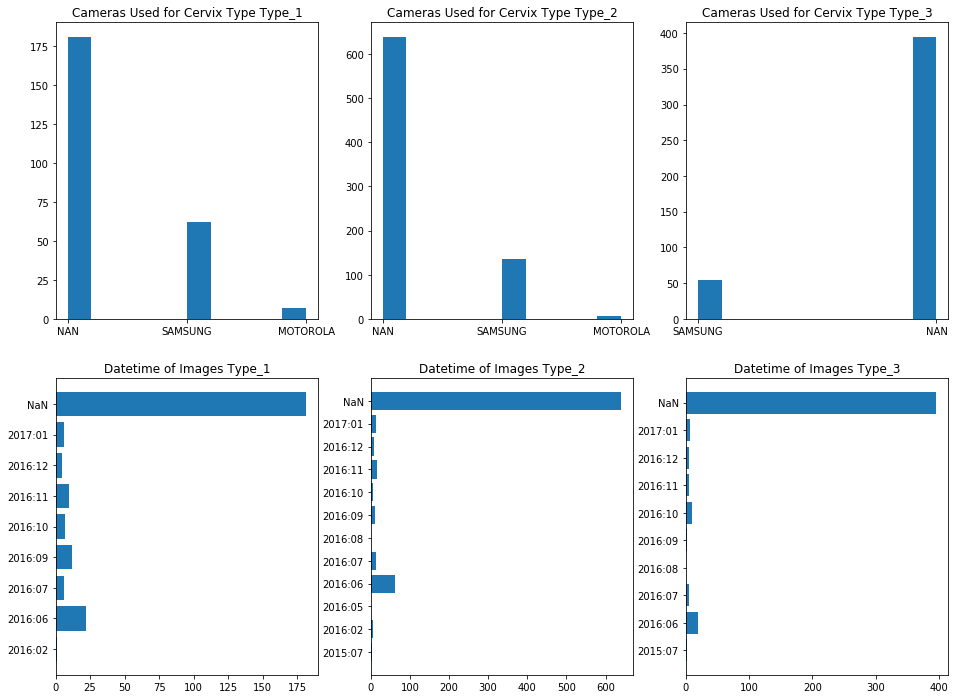

In [14]:
train_makes = {}
train_datetimes = {}
fig = plt.figure(figsize=(16,12))
for i, t in enumerate(train.type.unique()):
    df = train[train.type==t]
    paths = df.imagepath
    train_make = []
    train_datetime = []
    for path in paths:
        exif_dict = get_exif(path)
        if exif_dict == 'NaN':
            train_make.append('NaN')
            train_datetime.append('NaN')
        else:
            train_make.append(exif_dict['Make'])
            train_datetime.append(exif_dict['DateTime'][:7])
    train_makes[t] =train_make
    train_datetimes[t] = train_datetime
    ax1 = fig.add_subplot(2, 3, i+1)
    train_make = [x.upper() for x in train_make]
    ax1.hist(train_make)
    ax1.set_title('Cameras Used for Cervix Type {}'.format(t))
    ax2 = fig.add_subplot(2, 3, i+4)
    date, count = np.unique(train_datetime, return_counts= True)
    ax2.barh(date, count)
    ax2.set_title('Datetime of Images {}'.format(t))

According to all the histogram plots and bar graphs above, if we ignore the NaN data, all images were either taken by Samsung or Motorola. June of 2016 seems to be the time that most images were collected the most. 

Let's now take a look at the average image for each cervix type of the train set and the average image of the test dataset. In addition, we are also curious which image is the min or max based on ranking the norms of the image vectors. 

## Explainatory Data Analysis for the Training Dataset

In [15]:
#Take a brief look at the structure of the train images dataframe
train_df.head()

,type,img_array
0,Type_1,"[[[0, 0, 0], [0, 0, 0], [1, 1, 1], [1, 1, 1], ..."
1,Type_1,"[[[31, 85, 105], [47, 96, 118], [57, 99, 119],..."
2,Type_1,"[[[252, 235, 207], [252, 231, 204], [253, 232,..."
3,Type_1,"[[[162, 148, 190], [145, 136, 179], [153, 143,..."
4,Type_1,"[[[71, 32, 24], [78, 39, 25], [93, 53, 35], [1..."


#### Average Image for Each Cervix Type

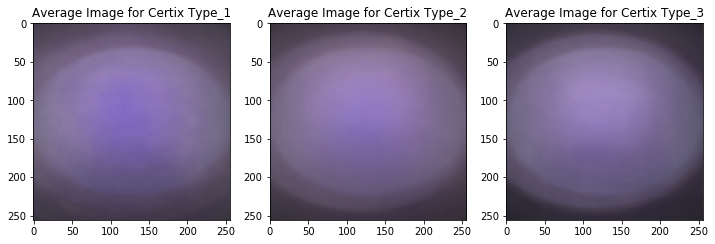

In [16]:
fig = plt.figure(figsize=(12,8))
for i, t in enumerate(train_df.type.unique()):
    ax = fig.add_subplot(1,3,i+1)
    img_list = train_df[train_df.type==t]['img_array']
    arr = np.zeros((h, w, 3), np.float)
    for img in img_list:
        arr = arr + img/len(img_list)
    arr = np.array(np.round(arr), dtype=np.uint8)
    out = Image.fromarray(arr)
    plt.imshow(out)
    plt.title('Average Image for Certix {}'.format(t))  

It appears that Type_1 cervix has more purple pixel at the center of the average image. Next is Type_2 and Type_3 does not have much color contrast in its average image. 

#### Find Min and Max Image Based on Norm Vectors

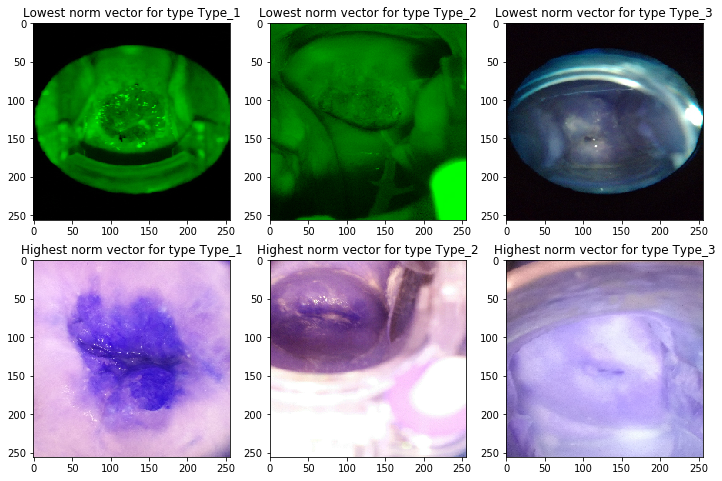

In [17]:
fig = plt.figure(figsize=(12,8))
for i, t in enumerate(train_df.type.unique()):
    ax1 = fig.add_subplot(2,3,i+1)
    ax2 = fig.add_subplot(2,3,i+4)
    norms = [[], [], []]
    for value in train_df[train_df.type == t].img_array.values:
        norm = np.linalg.norm(value)
        norms[i].append(norm)
    ax1.imshow(train_df[train_df.type==t].img_array.values[norms[i].index(min(norms[i]))])
    ax1.set_title('Lowest norm vector for type {}'.format(t))
    ax2.imshow(train_df[train_df.type==t].img_array.values[norms[i].index(max(norms[i]))])
    ax2.set_title('Highest norm vector for type {}'.format(t))


Based on the min and max images found by ranking the norms, the min images of all three types have darker features while the max images have brighter color features. 

## Explainatory Data Analysis for the Test Dataset

#### Average Image for the Test Dataset

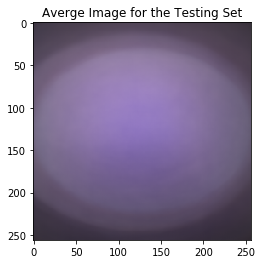

In [18]:
arr = np.zeros((h, w, 3), np.float)
for img in test_imgs:
    arr = arr + img/len(test_imgs)
arr = np.array(np.round(arr), dtype=np.uint8)
out = Image.fromarray(arr)
plt.title('Averge Image for the Testing Set')
plt.imshow(out)

#### Finding Min and Max Mmage from Test Dataset Based on Norm Vector

Text(0.5,1,'Max_Test_Image')

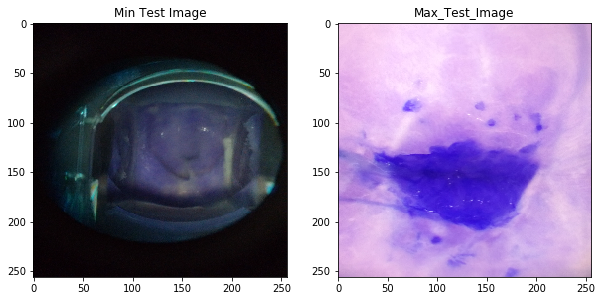

In [19]:
test_norms = []
for img in test_imgs:
    test_norm = np.linalg.norm(img)
    test_norms.append(test_norm)
min_test_norm = min(test_norms)
max_test_norm = max(test_norms)

min_tnorm_index = test_norms.index(min_test_norm)
max_tnorm_index = test_norms.index(max_test_norm)

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(test_imgs[min_tnorm_index])
ax1.set_title('Min Test Image')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(test_imgs[max_tnorm_index])
ax2.set_title('Max_Test_Image')

The same behaviors are observed in the case of the test dataset: max image seems to have lighter features and min image has much darker features. 